# LSTM model full data

# Set up notebook

In [0]:
!nvidia-smi

Fri Jan  3 14:48:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install sentencepiece

In [0]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
#root_path = 'drive/My Drive/Colab_Notebooks/deeplearning/Sentence_VAE/'
root_path = '/content/drive/My Drive/Colab Notebooks/Sentence_VAE/'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Import modules

In [0]:
import torch
from torch import optim
from IPython.display import Image, display, clear_output
import sentencepiece as spm
import pickle

from torch.utils.data import DataLoader
import time


# Load data and SentencePiece model (See respective notebooks to see how they are made)

#### Load pickle with preprocessed data

In [0]:
data_dict = pickle.load(open(root_path + "FREM_data_set_sub10.p", "rb"))
training_data = data_dict["FR"]["train"]["formal"] + data_dict["FR"]["train"]["informal"] + data_dict["EM"]["train"]["formal"] + data_dict["EM"]["train"]["informal"]
test_data = data_dict["FR"]["test"]["formal"] + data_dict["FR"]["test"]["informal"] + data_dict["EM"]["test"]["formal"] + data_dict["EM"]["test"]["informal"] 
print("EM part")
print(f"train formal len: {len(data_dict['EM']['train']['formal'])}")
print(f"train informal len: {len(data_dict['EM']['train']['informal'])}")
print(f"test formal len: {len(data_dict['EM']['test']['formal'])}")
print(f"test informal len: {len(data_dict['EM']['test']['informal'])}")
print("\nFR part")
print(f"train formal len: {len(data_dict['FR']['train']['formal'])}")
print(f"train informal len: {len(data_dict['FR']['train']['informal'])}")
print(f"test formal len: {len(data_dict['FR']['test']['formal'])}")
print(f"test informal len: {len(data_dict['FR']['test']['informal'])}")
print("\nData sizes")
print(f"training data len: {len(training_data)}")
print(f"test data len: {len(test_data)}")

EM part
train formal len: 14557
train informal len: 14557
test formal len: 719
test informal len: 719

FR part
train formal len: 13083
train informal len: 13083
test formal len: 606
test informal len: 606

Data sizes
training data len: 55280
test data len: 2650


#### Load SentencePiece model

In [0]:
# Load sentencepiece model (See local notebook for how to create the sentencepiece model)
sp = spm.SentencePieceProcessor()
sp.Load(root_path + 'fulltraintest32000.model')
VOCAB_SIZE = 32000

# Setting up model Model

### model

In [0]:
from torch import nn

In [0]:
class LSTM_model(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, seq_length):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim
    self.seq_length = seq_length

    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    
    self.dropout = nn.Dropout(p=0.2)

    self.lstm = nn.LSTM(input_size=embedding_dim,
              hidden_size=hidden_dim,
              batch_first = True,
              num_layers=1)
    
    self.linear_out = nn.Linear(in_features=hidden_dim,
                                out_features=vocab_size)
    
  def forward(self, sentence):
    embeds = self.word_embeddings(sentence[:, :-1])
    #embeds = self.dropout(embeds)
    x, (h, c) = self.lstm(embeds)
    output = self.linear_out(x)
    return output

In [0]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
BATCH_SIZE = 1024
SEQ_LEN = 12 #padded + EOS + SOS

lstm =  LSTM_model(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                   vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN).cuda()

### Data loader

In [0]:
from torch.utils.data import DataLoader
train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE)



### Optimizer

In [0]:
optimizer = optim.Adam(lstm.parameters(), lr=0.0006)

### Loss function

In [0]:
from torch.nn import functional as F

def loss_func(recon_sentence, sentence):
  # Reconstruction error, log[p(x|z)]
  # Sum over features
  CE = F.cross_entropy(recon_sentence, sentence, reduction='none') # Is the loss function correct?
  CE = CE.sum(1).mean()

  return CE

### Training and test functions

In [0]:
def train(epoch):
    lstm.train()
    start_time = time.time()
    epoch_loss = 0
    for index, sentence in enumerate(train_data_loader):
        sentence = torch.LongTensor(sentence)
        sentence = sentence.cuda()
        optimizer.zero_grad()
        output = lstm.forward(sentence)
        loss = loss_func(output.permute(0,2,1), sentence[:,1:])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= N_train
    return epoch_loss


def test(epoch):
    lstm.eval()
    with torch.no_grad(): # No grads needed and we don't want to run out of mem
      epoch_loss = 0
      for index, sentence in enumerate(test_data_loader):
          sentence = torch.LongTensor(sentence)
          sentence = sentence.cuda()
          output = lstm.forward(sentence)
          loss = loss_func(output.permute(0,2,1), sentence[:,1:])
          epoch_loss += loss.item()
      epoch_loss /= N_test
    return epoch_loss


# simpler plot for LSTM model

import matplotlib.pyplot as plt

def plot_loss(train_arr, test_arr):
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.plot(train_arr)
  plt.plot(test_arr)
  plt.legend(['Train', 'Test'])
  plt.show()

## Training loop

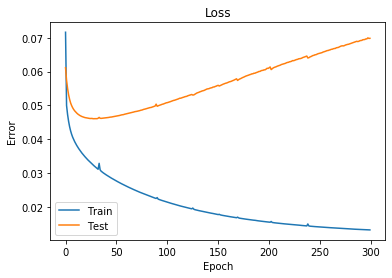

Epoch 299: time: 14.04446816444397
loss: 0.013306588460671056


In [0]:
N_epochs = 600
N_train = len(training_data)
N_test = len(test_data)


train_loss_arr = []
test_loss_arr = []
for epoch in range(N_epochs//2):
    lstm.train()
    start = time.time()

    train_loss = train(epoch)
    train_loss_arr.append(train_loss)


    test_loss = test(epoch)
    test_loss_arr.append(test_loss)
 

    plot_loss(train_loss_arr, test_loss_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"loss: {train_loss}")
    clear_output(wait=True)

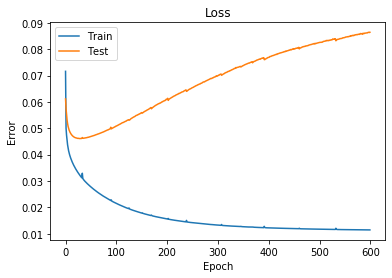

Epoch 599: time: 14.018742561340332
loss: 0.01143765744528101


In [0]:
for epoch in range(N_epochs//2, N_epochs):
    lstm.train()
    start = time.time()

    train_loss = train(epoch)
    train_loss_arr.append(train_loss)


    test_loss = test(epoch)
    test_loss_arr.append(test_loss)
 

    plot_loss(train_loss_arr, test_loss_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"loss: {train_loss}")
    clear_output(wait=True)

#### save model

In [0]:
torch.save(lstm.state_dict(), root_path + "trained_models/" + "lstm_model_fulldata.pt")

#### Optional load model

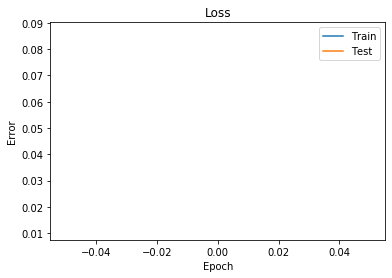

Epoch 0: time: 13.968397855758667
loss: 0.011250615775498915


In [0]:
N_epochs = 600
N_train = len(training_data)
N_test = len(test_data)
train_loss_arr = []
test_loss_arr = []

lstm =  LSTM_model(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN).cuda()

lstm.load_state_dict(torch.load(root_path + "trained_models/" + "lstm_model_fulldata.pt"))

for epoch in range(1):
    lstm.train()
    start = time.time()

    train_loss = train(epoch)
    train_loss_arr.append(train_loss)


    test_loss = test(epoch)
    test_loss_arr.append(test_loss)
 

    plot_loss(train_loss_arr, test_loss_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"loss: {train_loss}")
    clear_output(wait=True)


## Results

#### Loss of trained model

In [0]:
print(f"Loss \nTrain: {train_loss_arr[-1]} Test: {test_loss_arr[-1]}")

Loss 
Train: 0.011250615775498915 Test: 0.08641130843252506


#### Qualitative results

In [0]:
import numpy as np

In [0]:
def print_single_reconstruction_with_corrections(sentence_in_batch, data_loader):
    lstm.eval()
    test_batch = next(iter(data_loader))
    test_sentence = test_batch[sentence_in_batch]
    test_sentence_string = sp.decode_ids(test_sentence.tolist())
    output = lstm.forward(test_sentence.unsqueeze(0).cuda()) # This view needs to be double checked
    output = torch.sigmoid(output)
    output_ids = output[0,:,:]
    recon_ids = [int(np.argmax(word)) for word in output_ids.cpu().detach().numpy()]
    recon_sentence = sp.decode_ids(recon_ids)
    recon_print = "Reconstructed sentence:"
    real_print = "Real sentence:"
    print(f"{recon_print:<30} {recon_sentence:<50}\n")
    print(f"{real_print:<30} {test_sentence_string:<50}")
    lstm.train()



In [0]:
  print_single_reconstruction_with_corrections(sentence_in_batch=1, data_loader=train_data_loader)

Reconstructed sentence:        i, have love but reggaeton is better.             

Real sentence:                 yes i do, but reggaeton is better.                


In [0]:
def print_single_reconstruction(sentence_in_batch, data_loader):
    lstm.eval()
    test_batch = next(iter(data_loader))
    test_sentence = test_batch[sentence_in_batch]
    test_sentence_string = sp.decode_ids(test_sentence.tolist())
    iterative_sentence_string = test_sentence[0]
    for i in range(len(test_sentence)):
      output = 

In [0]:
for i in range(10):
  print_single_reconstruction_with_corrections(sentence_in_batch=i, data_loader=train_data_loader)
  print('*******')

Reconstructed sentence:        i am to him immense amount of christian music.    

Real sentence:                 i listen to an immense amount of christian music. 
*******
Reconstructed sentence:        i is on the age.                                  

Real sentence:                 it depends on your mood.                          
*******
Reconstructed sentence:        i a out magazine subscription to something he likes.

Real sentence:                 get him a magazine subscription to something he likes.
*******
Reconstructed sentence:        i am not know that she sued her father.           

Real sentence:                 i did not know that she sued her father.          
*******
Reconstructed sentence:        i am just to say this one too.                    

Real sentence:                 i was going to ask this one too!                  
*******
Reconstructed sentence:        i should you is your best best..                  

Real sentence:                 you said this i

In [0]:
for i in range(10):
  print_single_reconstruction_with_corrections(sentence_in_batch=i, data_loader=test_data_loader)
  print('*******')

Reconstructed sentence:        i you asking a question number?                   

Real sentence:                 are you posing a rhetorical question?             
*******
Reconstructed sentence:        i am not know to be racist.                       

Real sentence:                 i do not intend to be mean.                       
*******
Reconstructed sentence:        i him if you can stay with it..                   

Real sentence:                 ask him if you should go see a doctor.            
*******
Reconstructed sentence:        i, you dance ask to see again!                    

Real sentence:                 also, i would like to try again.                  
*******
Reconstructed sentence:        i are the- what                                   

Real sentence:                 women are coomplicated.                           
*******
Reconstructed sentence:        i things is not interesting than ass              

Real sentence:                 doing that does sound